In [1]:
import torch 
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import ncps 
from ncps.torch import LTC
from ncps.torch import CfC
from ncps.wirings import AutoNCP
import pytorch_lightning as pl
import torch.utils.data as data
import seaborn as sns

# Lorenz System, Helper Functions

In [2]:
initial_point = np.array([10.61098536,  5.87720862, 34.48052002])
params = [10, 28, 8/3]
dt = 0.001

num_samples = [100_000, 20_000, 5_000]

def dpdt(point, params=params): #position

    x,y,z = point
    sig, rho, beta = params
    
    new_x = y*dt*sig + x*(1-dt*sig)
    new_y = x*dt*(rho-z) + y*(1-dt)
    new_z = x*y*dt + z*(1-dt*beta)
    return np.array([new_x, new_y, new_z])

def make_lorenz_rollout(num_samples):
    positions = []
    positions.append(initial_point)

    # your dataset
    for _ in range(num_samples):
        positions.append(dpdt(positions[-1]))

    positions = np.stack(positions)

    labels = np.sum(np.sqrt(np.square(positions[1:num_samples+1] - positions[:num_samples])), axis=1)

    return positions, labels

In [3]:
test_samples = num_samples[1]
positions, _ = make_lorenz_rollout(test_samples)

print(positions.shape)

p_max = np.max(positions)
p_min = np.min(positions)

# Add noise
#positions = positions +np.random.randn(test_samples + 1,3) * 0.1

# Scale
positions = positions/p_max # (normalize to between 1 some negative number that won't be 1) 

(20001, 3)


In [4]:
data_x = positions[:test_samples]
data_y = positions[1:test_samples+1]
print(data_x[1], " ", data_y[0])
print(data_x.shape)

[0.24245124 0.13317744 0.7906996 ]   [0.24245124 0.13317744 0.7906996 ]
(20000, 3)


In [5]:
# LightningModule for training a RNNSequence module
class SequenceLearner(pl.LightningModule):
    def __init__(self, model, lr=0.005):
        super().__init__()
        self.model = model
        self.lr = lr

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat, _ = self.model.forward(x)
        y_hat = y_hat.view_as(y)
        loss = nn.MSELoss()(y_hat, y)
        self.log("train_loss", loss, prog_bar=True)
        return {"loss": loss}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat, _ = self.model.forward(x)
        y_hat = y_hat.view_as(y)
        loss = nn.MSELoss()(y_hat, y)

        self.log("val_loss", loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        # Here we just reuse the validation_step for testing
        return self.validation_step(batch, batch_idx)

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)

In [6]:
class MultiStepSeqLearner(pl.LightningModule):
    def __init__(self, model, length=3, lr=0.005):
        super().__init__()
        self.model = model
        self.lr = lr
        self.length = length

    def training_step(self, batch, batch_idx):
        ''' This is with the assumption that the batches will come in of something like 
        batch = (x, y) where x and y both have shape
        shape=(batch_size, trajectory_length, input_space)'''
        x, y = batch
        rolling_inputs = x
        predictions = []
        
        for i in range(self.length):
            
            prediction = self.model.forward(rolling_inputs)[0]
                
            predictions.append(prediction)
            #print(prediction.unsqueeze(axis=1).shape)
            #print(rolling_inputs.shape)
            rolling_inputs = torch.concatenate((rolling_inputs[:, 1:self.length+1, :], prediction.unsqueeze(axis=1)), axis=1)
        

        predictions = torch.stack(predictions)
        predictions = torch.swapaxes(predictions, 0, 1)
        #print(predictions.shape, " ", y.shape)
        #trajectory = trajectory.view_as(y)
        #print(trajectory.shape)
        loss = nn.MSELoss()(predictions, y)
        self.log("train_loss", loss, prog_bar=True)
        return {"loss": loss}
        
            
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat, _ = self.model.forward(x)
        y_hat = y_hat.view_as(y)
        loss = nn.MSELoss()(y_hat, y)

        self.log("val_loss", loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        # Here we just reuse the validation_step for testing
        return self.validation_step(batch, batch_idx)

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)

In [65]:
# now we have to make them into batches of sequence lengths
x = []
y = []
traj_len = 5
look_ahead = 3
for i in range(test_samples - traj_len - look_ahead):
    x.append(positions[i:i+traj_len])
    y.append(positions[i+traj_len:i+traj_len+look_ahead])

#print(x, y[0])
#print(" ")
#print(x, y[1])
data_x = np.stack(x)
data_y = np.stack(y)

In [66]:
print(data_x.shape, " ", data_y.shape)
print(data_x[0, :, :], "\n woah \n ", data_y[0, :, :], "\n ahh \n ", data_x[1, -1, :])


(19992, 5, 3)   (19992, 3, 3)
[[0.24353771 0.13489058 0.79137863]
 [0.24245124 0.13317744 0.7906996 ]
 [0.2413585  0.13148022 0.78999791]
 [0.24025972 0.12979913 0.7892739 ]
 [0.23915512 0.12813436 0.78852793]] 
 woah 
  [[0.23804491 0.12648608 0.78776035]
 [0.23692932 0.12485447 0.78697153]
 [0.23580857 0.12323968 0.78616182]] 
 ahh 
  [0.23804491 0.12648608 0.78776035]


# NCPS

In [90]:
from ncps.wirings import NCP
out_features = 3
in_features = 3

#wiring = AutoNCP(6, out_features)  
wiring = NCP(inter_neurons=5, command_neurons=3, motor_neurons=out_features,
             sensory_fanout=5, inter_fanout=2, recurrent_command_synapses=3, motor_fanin=2)

world_model = CfC(in_features, wiring, batch_first=True, return_sequences=False, activation = "tanh", mixed_memory=True) # change to cfc, what could go wrong?

In [1037]:
# Alternatively, make just an LTC
#world_model = LTC(in_features, out_features, batch_first=True, return_sequences=False)

## Test if I can save the wirings and weights

In [1038]:
PATH = "models/LTC_state_dict"
torch.save(world_model.state_dict(), PATH)

adj_mat = wiring.adjacency_matrix
sens_mat = wiring.sensory_adjacency_matrix 

#wm.load_state_dict(torch.load(PATH, weights_only=True))

# Visualization and Training

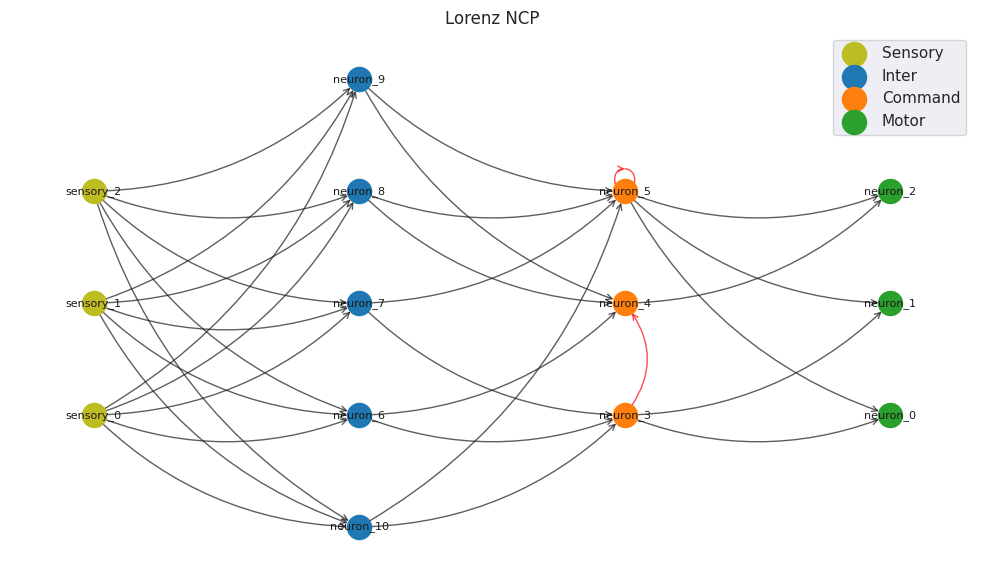

In [80]:
import matplotlib.pyplot as plt
import networkx as nx

# Obtain the graph from the wiring.
G = wiring.get_graph()

# Separate nodes by type.
sensory_nodes = [node for node, data in G.nodes(data=True) if data.get("neuron_type") == "sensory"]
inter_nodes   = [node for node, data in G.nodes(data=True) if data.get("neuron_type") == "inter"]
command_nodes = [node for node, data in G.nodes(data=True) if data.get("neuron_type") == "command"]
motor_nodes   = [node for node, data in G.nodes(data=True) if data.get("neuron_type") == "motor"]

# Assign fixed x-coordinates for a feed-forward layout:
# x = 0 for sensory, 2 for inter, 4 for command, and 6 for motor.
pos = {}
layers = [
    ("sensory", sensory_nodes),
    ("inter", inter_nodes),
    ("command", command_nodes),
    ("motor", motor_nodes)
]
x_spacing = 2.0  # horizontal spacing between layers
y_spacing = 1.0  # vertical spacing within a layer

for layer_index, (layer_name, nodes) in enumerate(layers):
    x = layer_index * x_spacing
    n = len(nodes)
    # Evenly space nodes vertically and center them if there's more than one.
    for i, node in enumerate(sorted(nodes)):
        y = (i - (n - 1) / 2) * y_spacing if n > 1 else 0
        pos[node] = (x, y)

# Separate edges into non-recurrent and recurrent (command -> command) edges.
non_recurrent_edges = []
recurrent_edges = []
for u, v, d in G.edges(data=True):
    # If both source and target are command neurons, mark as recurrent.
    if G.nodes[u]["neuron_type"] == "command" and G.nodes[v]["neuron_type"] == "command":
        recurrent_edges.append((u, v))
    else:
        non_recurrent_edges.append((u, v))


plt.figure(figsize=(10, 6))

# Draw nodes with different colors for each layer.
nx.draw_networkx_nodes(G, pos, nodelist=sensory_nodes, node_color='tab:olive', label='Sensory')
nx.draw_networkx_nodes(G, pos, nodelist=inter_nodes,   node_color='tab:blue',   label='Inter')
nx.draw_networkx_nodes(G, pos, nodelist=command_nodes, node_color='tab:orange', label='Command')
nx.draw_networkx_nodes(G, pos, nodelist=motor_nodes,   node_color='tab:green',  label='Motor')

# Draw non-recurrent edges with a gentle curve.
nx.draw_networkx_edges(
    G, pos,
    edgelist=non_recurrent_edges,
    arrows=True,
    arrowstyle='->',
    connectionstyle='arc3, rad=0.2',  # gentle curve
    alpha=0.7
)

# Draw recurrent edges with a more pronounced curve and a different color.
nx.draw_networkx_edges(
    G, pos,
    edgelist=recurrent_edges,
    arrows=True,
    arrowstyle='->',
    connectionstyle='arc3, rad=0.4',  # increased curvature
    edge_color='red',
    alpha=0.7
)

# Draw node labels.
nx.draw_networkx_labels(G, pos, font_size=8)

plt.axis('off')
plt.title("Lorenz NCP")
plt.legend()
plt.tight_layout()
plt.show()


In [91]:
learn = MultiStepSeqLearner(world_model, lr=1e-2, length = look_ahead)

trainer = pl.Trainer(
    logger=pl.loggers.CSVLogger("log"),
    max_epochs=5,
    gradient_clip_val=1,  # Clip gradient to stabilize training
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [92]:

import torch.utils.data as data
inputs = torch.tensor(data_x, dtype=torch.float32)
outputs = torch.tensor(data_y, dtype=torch.float32).squeeze(axis=1)

print(outputs.shape)

dataloader = data.DataLoader(
    data.TensorDataset(inputs, outputs), batch_size=16, shuffle=True, num_workers=24
)

torch.Size([19992, 3, 3])


In [93]:
trainer.fit(learn, dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | CfC  | 1.1 K  | train
---------------------------------------
1.0 K     Trainable params
82        Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)
29        Modules in train mode
0         Modules in eval mode


Training: |                                                                                       | 0/? [00:00…

`Trainer.fit` stopped: `max_epochs=5` reached.


In [73]:
inputs.shape

torch.Size([19992, 5, 3])

In [74]:
# Save NCPS Network
num_s = str(test_samples)
PATH = f"models/NCPS_N{num_s}"
torch.save(world_model.state_dict(), PATH)

#with open(PATH + '/adj_mat.npy', 'wb') as f:
#    np.save(f, wiring.adjacency_matrix)

#with open(PATH + '/sens_mat.npy', 'wb') as f:
#    np.save(f, wiring.sensory_adjacency_matrix )



In [86]:
# NCPS Residuals
x_residuals = []
y_residuals = []
ang_vel_residuals = []

set_of_predictions = []

with torch.no_grad():
    prediction = world_model(inputs)[0].numpy()
print(prediction.shape)
# save predictions
#print("PRED: ", prediction)

set_of_predictions.append(prediction)

print(data_y.shape)

# get residuals
#x_residuals.append(prediction[:, 0] - y[:, 0])
#y_residuals.append(prediction[:, 1] - y[:, 1])
#ang_vel_residuals.append(prediction[:, 2] - y[:, 2])

#NCPS_x_res = np.stack(x_residuals).T
#NCPS_y_res = np.stack(y_residuals).T
#NCPS_ang_res = np.stack(ang_vel_residuals).T


(19992, 3)
(19992, 3, 3)


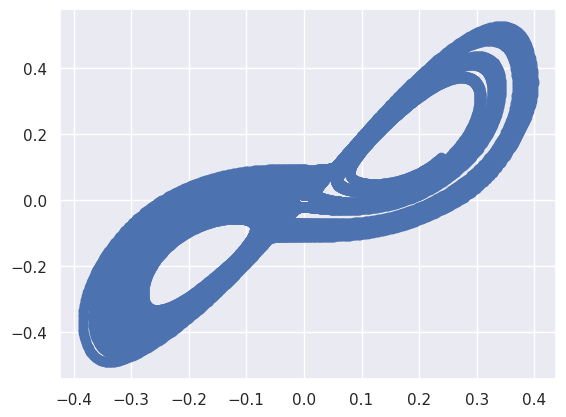

In [87]:
plt.scatter(prediction[:, 0], prediction[:, 1])
#set_of_predictions.shape

Text(0.5, 1.0, 'NCPS, trained with 5-step look ahead')

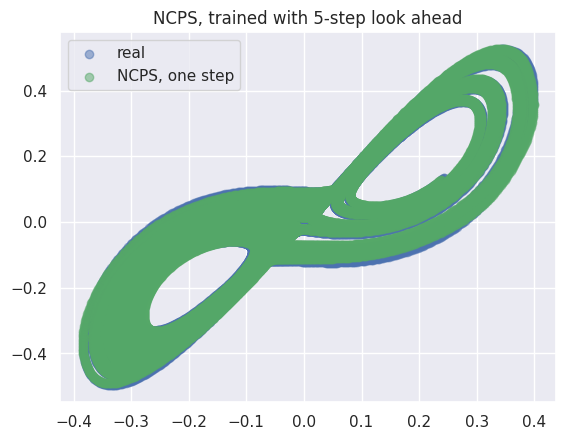

In [88]:
sns.set()
plt.scatter(positions[:, 0], positions[:, 1], alpha=0.5, label="real")
plt.scatter(prediction[:, 0], prediction[:, 1], alpha=0.5, color='g', label="NCPS, one step")
plt.legend()
plt.title("NCPS, trained with 5-step look ahead")

Text(0.5, 1.0, 'NCPS, trained with 5-step look ahead')

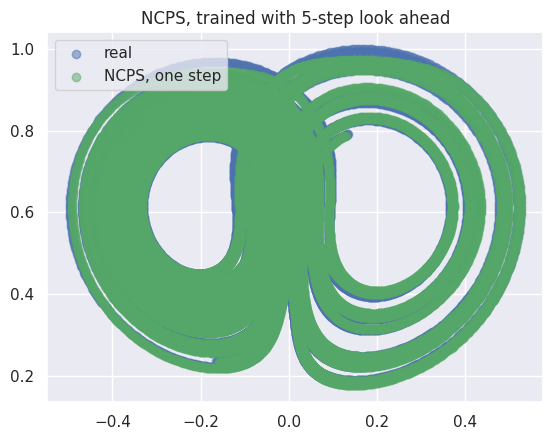

In [89]:
plt.scatter(positions[:, 1], positions[:, 2], alpha=0.5, label="real")
plt.scatter(prediction[:, 1], prediction[:, 2], alpha=0.5, color='g', label="NCPS, one step")
plt.legend()
plt.title("NCPS, trained with 5-step look ahead")

For my own sanity, I should start documenting what it is that I'm doing here.

In this case, what we have is that upon recieving real inputs with time correspondance to them, we can achieve pretty solid results. Now, I want to see what that our model looks like when we try to achieve more than one step prediction.

I see two paths forward here. If we set an arbitrary time window ahead and set our model to be unable to go past that line, then we would expect worse results as opposed to not having a time window at all. The upside then is then we reduce compute time. 

How much worse results, we can test for. How much worse compute time, probably not.

In [32]:
# I'm experimenting with now we stick with a 20-step time-window. See how far into the future we can get.

rolling_inputs = inputs[0]

window = inputs.shape[1]

predictions = []

num_predictions = 1_000

for i in range(num_predictions):
    with torch.no_grad():
        prediction = world_model(rolling_inputs)[0]
        
    predictions.append(prediction)
    #prediction = torch.FloatTensor(np.expand_dims(prediction, axis=0))
    #print(rolling_inputs.shape[0])
    if rolling_inputs.shape[0] > window:
        rolling_inputs = torch.concatenate((rolling_inputs[1:window+1], prediction.unsqueeze(0)))
    else:
         rolling_inputs = torch.concatenate((rolling_inputs, prediction.unsqueeze(0)))

    #print(rolling_inputs, " ", prediction)


predictions = torch.stack(predictions)
predictions.shape


torch.Size([1000, 3])

Text(0.5, 1.0, 'NCPS, trained with 5-step look ahead')

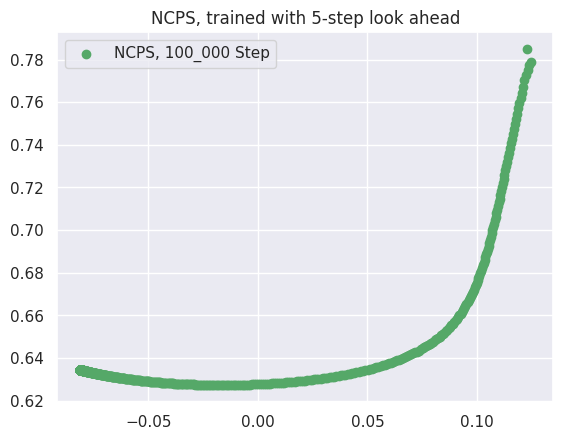

In [33]:
plt.scatter(predictions[:, 1], predictions[:, 2], color='g', label="NCPS, 100_000 Step")
#plt.scatter(y[3: 3 + num_predictions, 1], y[3: 3 + num_predictions, 2], alpha=0.5, color='b', label="real")
plt.legend()
plt.title("NCPS, trained with 5-step look ahead")

Text(0.5, 1.0, 'NCPS, trained with 5-step look ahead')

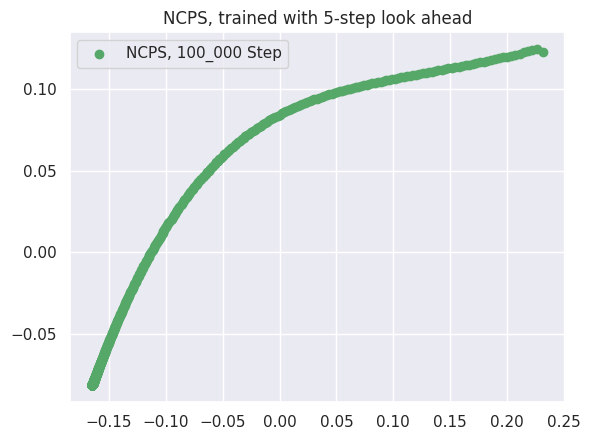

In [34]:
plt.scatter(predictions[:, 0], predictions[:, 1], color='g', label="NCPS, 100_000 Step")
#plt.scatter(y[3: 3 + num_predictions, 1], y[3: 3 + num_predictions, 2], alpha=0.5, color='b', label="real")
plt.legend()
plt.title("NCPS, trained with 5-step look ahead")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


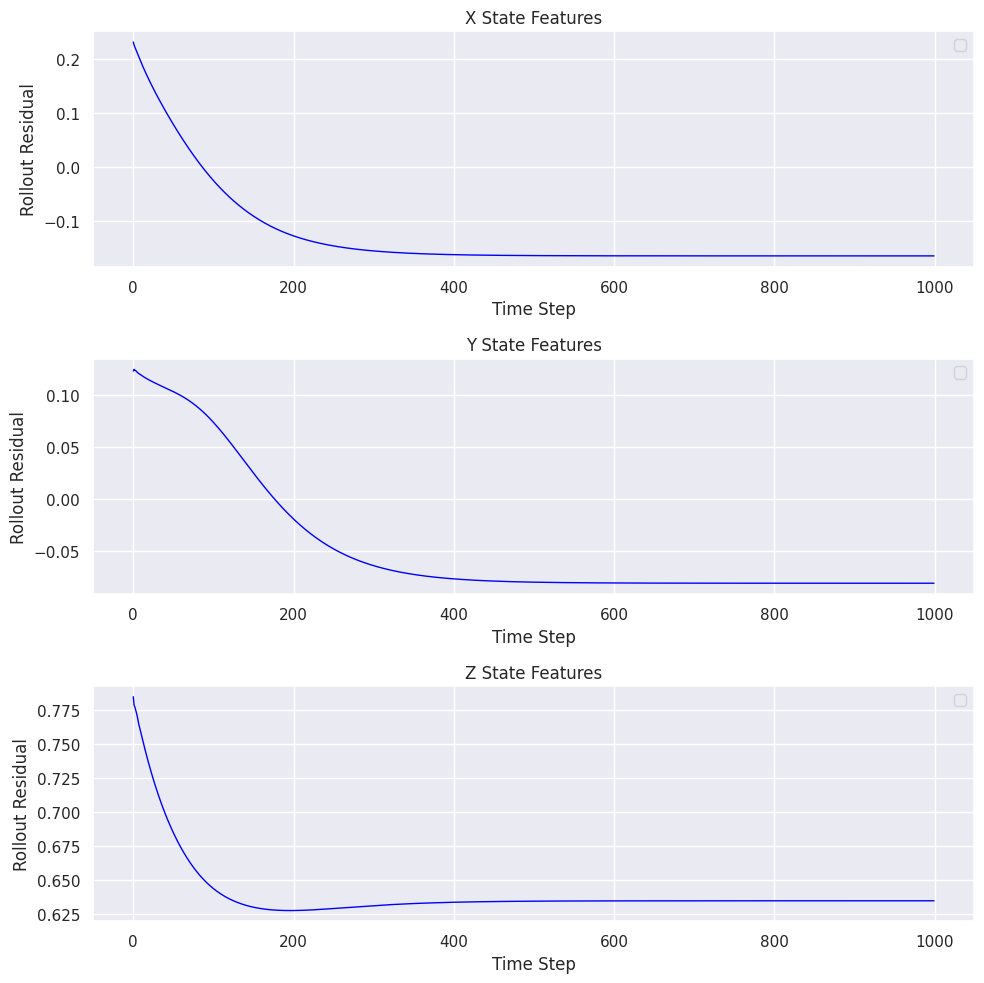

In [35]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 10))
time_steps = np.arange(num_predictions)

# Define a function to plot the residuals on a given axis
def plot_residuals(ax, res, title):
    # Plot all individual rollouts
    #for r in range(res.shape[0]):
    ax.plot(res, color='blue', alpha=1, linewidth=1)
    
    # Compute and plot the mean
    #mean_rollout = res.mean(axis=0)
    #ax.plot(mean_rollout, color='blue', linewidth=2, label='Mean Rollout')
    
    # Compute and plot ±1 std dev
    #std_rollout = res.std(axis=0)
    #ax.fill_between(time_steps, mean_rollout - std_rollout, mean_rollout + std_rollout,
    #              color='blue', alpha=0.2, label='Mean ± 1 Std. Dev.')
    
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Rollout Residual")
    ax.set_title(title)
    ax.legend(loc='upper right')

# Plot for x_res
plot_residuals(axes[0], predictions[:, 0], "X State Features")

# Plot for y_res
plot_residuals(axes[1], predictions[:, 1], "Y State Features")

# Plot for ang_res
plot_residuals(axes[2], predictions[:, 2], "Z State Features")

plt.tight_layout()
plt.show()

## Save Model

In [46]:
num_s = str(test_samples)
PATH = f"models/CFC_state_dict_N{num_s}"
torch.save(world_model.state_dict(), PATH + '/weights')

with open(PATH + '/adj_mat.npy', 'wb') as f:
    np.save(f, wiring.adjacency_matrix)

with open(PATH + '/sens_mat.npy', 'wb') as f:
    np.save(f, wiring.sensory_adjacency_matrix )



#wm = LTC(in_features, wiring, batch_first=True, return_sequences=False)

In [47]:
# test saved model

out_features = 3
in_features = 3

#wiring = AutoNCP(6, out_features)  
n_wir = NCP(inter_neurons=6, command_neurons=6, motor_neurons=out_features,
             sensory_fanout=4, inter_fanout=4, recurrent_command_synapses=4, motor_fanin=3)

num_s = str(test_samples)
PATH = f"models/CFC_state_dict_N{num_s}"

with open(PATH + '/adj_mat.npy', 'rb') as f:
    adj = np.load(f)

with open(PATH + '/sens_mat.npy', 'rb') as f:
    sens = np.load(f)

n_wir.adjacency_matrix = adj
n_wir.sensory_adjacency_matrix = sens

liquid = CfC(in_features, n_wir, batch_first=True, return_sequences=False) # change to cfc, what could go wrong?
liquid.load_state_dict(torch.load(PATH+ "/weights", weights_only=True))




IndexError: index 9 is out of bounds for axis 0 with size 9

In [ ]:
# NCPS Residuals
x_residuals = []
y_residuals = []
ang_vel_residuals = []

set_of_predictions = []

with torch.no_grad():
    n_prediction = liquid(inputs)[0].numpy()
print(prediction.shape)
# save predictions
#print("PRED: ", prediction)

set_of_predictions.append(prediction)

print(y.shape)

# get residuals
#x_residuals.append(prediction[:, 0] - y[:, 0])
#y_residuals.append(prediction[:, 1] - y[:, 1])
#ang_vel_residuals.append(prediction[:, 2] - y[:, 2])

#NCPS_x_res = np.stack(x_residuals).T
#NCPS_y_res = np.stack(y_residuals).T
#NCPS_ang_res = np.stack(ang_vel_residuals).T


sns.set()
plt.scatter(y[:, 0], y[:, 1], alpha=0.5, label="real")
plt.scatter(n_prediction[:, 0], n_prediction[:, 1], alpha=0.5, color='g', label="NCPS, one step")
plt.legend()
plt.title("NCPS, trained with 5-step look ahead")

# DNN (Residual Connection)

In [48]:
import tensorflow as tf

def build_world_model_residual():
    xin_s = tf.keras.layers.Input((3,))

    xs = tf.keras.layers.Dense(32, activation='swish')(xin_s)
    xs = tf.keras.layers.Dense(32, activation='swish')(xs)
    xs = tf.keras.layers.Dense(3)(xs)

    xout = tf.keras.layers.Add()([xs,xin_s])
    return tf.keras.models.Model(xin_s, xout)

build_world_model_residual().summary()

2025-03-05 00:39:08.223216: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-05 00:39:08.745833: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-05 00:39:10.078234: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2025-03-05 00:39:11.100937: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │        128 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      1,056 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 3)         │         99 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 3)         │          0 │ dense_2[0][0],    │
│                     │                   │            │ input_layer[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,283 (5.01 KB)

 Trainable params: 1,283 (5.01 KB)

 Non-trainable params: 0 (0.00 B)

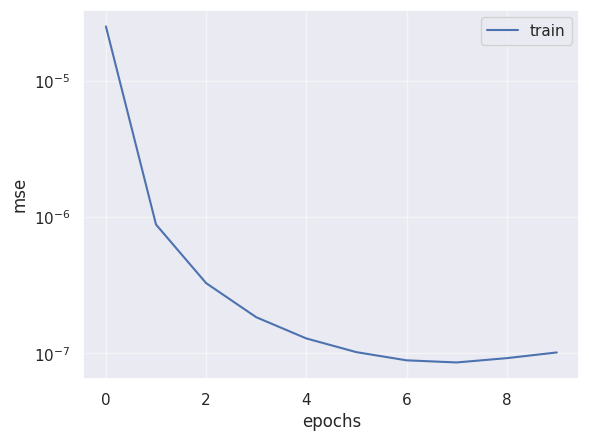

In [49]:
world_model_res = build_world_model_residual()
world_model_res.compile(loss='mse',optimizer='adam')

hist = world_model_res.fit(positions[:-1],
                           positions[1:],
                           batch_size = 64, epochs = 10, verbose=0)

plt.plot(hist.history['loss'],label='train')
plt.xlabel('epochs')
plt.ylabel('mse')
plt.legend()
plt.yscale('log')
plt.grid(alpha=0.5);


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Text(0.5, 1.0, '500 steps forward')

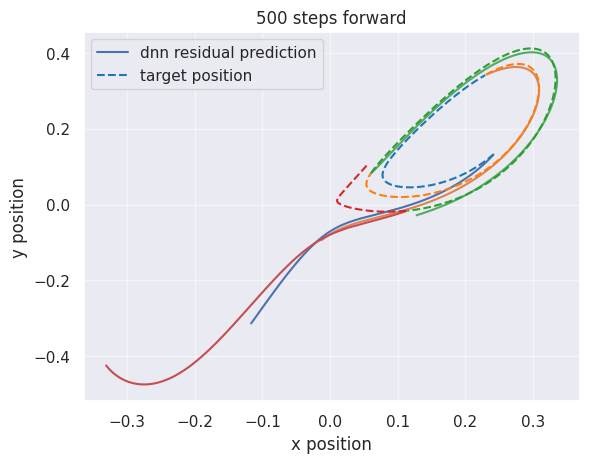

In [50]:
offsets = [0, 500, 1000, 1500]
#positions[offsets]

# roll out with random actions
# evaluate by length of pendulum and disc
_state = np.array(world_model_res.predict(positions[offsets].reshape(4,3))).reshape(4,3)

pred_pos = list()
for i in range(500):
    # random action
    _state = np.array(world_model_res(_state.reshape(4,3))).squeeze()
    # pend length
    pred_pos.append(_state)

pred_pos = np.array(pred_pos)

pred_pos.shape

plt.plot(pred_pos[:,0,0],pred_pos[:,0,1],label='dnn residual prediction')
plt.plot(positions[1:501,0],positions[1:501,1],label='target position',c='tab:blue',ls='--')
plt.legend()

plt.plot(pred_pos[:,1,0],pred_pos[:,1,1],label='dnn residual prediction')
plt.plot(positions[501:1001,0],positions[501:1001,1],label='target position',c='tab:orange',ls='--')

plt.plot(pred_pos[:,2,0],pred_pos[:,2,1],label='dnn residual prediction')
plt.plot(positions[1001:1501,0],positions[1001:1501,1],label='target position',c='tab:green',ls='--')

plt.plot(pred_pos[:,3,0],pred_pos[:,3,1],label='dnn residual prediction')
plt.plot(positions[1501:2001,0],positions[1501:2001,1],label='target position',c='tab:red',ls='--')
plt.xlabel('x position')
plt.ylabel('y position')
plt.grid(alpha=0.5)
plt.title('500 steps forward')

## Save Weights

In [51]:
# Save the weights
PATH = f"models/RESNET_state_dict_N{num_s}.weights.h5"
world_model_res.save_weights(PATH)

# Recurrent Net

In [52]:
class SimpleRNN(nn.Module):
    def __init__(self, obs_space_size, action_space_size, hidden_size):
        super().__init__()
        self.l0 = nn.Sequential(
            nn.Linear(obs_space_size + action_space_size, 32),
            nn.ReLU()
        )
        
        self.rnn = nn.RNN(32, hidden_size, batch_first=True)

        self.l1 = nn.Sequential(
            nn.Linear(hidden_size, 32),
            nn.ReLU(),
            nn.Linear(32, obs_space_size),
        )
        self.hidden_size = hidden_size

    def forward(self, x, h0=None):
        if h0 is None:
            h0 = torch.zeros(1, x.size(0), self.hidden_size)

        out = self.l0(x)
        out, ht = self.rnn(out, h0)
        out = self.l1(out)
        out = out[:, -1, :]
        return out, ht

In [53]:
# Instantiate your model
# Adjust obs_space_size, action_space_size, hidden_size to match your setup

# now we have to make them into batches of sequence lengths
x = []
y = []
traj_len = 5
look_ahead = 1
for i in range(test_samples - traj_len - look_ahead):
    x.append(positions[i:i+traj_len])
    y.append(positions[i+traj_len:i+traj_len+look_ahead])

#print(x, y[0])
#print(" ")
#print(x, y[1])
data_x = np.stack(x)
data_y = np.stack(y)

inputs = torch.tensor(data_x, dtype=torch.float32)
outputs = torch.tensor(data_y, dtype=torch.float32).squeeze(axis=1)

print(outputs.shape)

dataloader = data.DataLoader(
    data.TensorDataset(inputs, outputs), batch_size=16, shuffle=True, num_workers=24
)

obs_space_size = 3
action_space_size = 0
hidden_size = 16
model = SimpleRNN(obs_space_size, action_space_size, hidden_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
epochs = 20
for epoch in range(epochs):
    epoch_loss = 0.0
    for batch_X, batch_Y in dataloader:

        #print(batch_X.shape, " ", batch_Y.shape)
        
        # Reshape inputs/targets to (batch_size, seq_len, features).
        # Here we treat each sample as a sequence of length 1.
        # If you have a longer sequence, reshape accordingly.
        batch_X = batch_X # shape -> [batch_size, 1, input_dim]
        batch_Y = batch_Y  # shape -> [batch_size, 1, obs_space_size]

        # Reset gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs, _ = model(batch_X)

        #print(outputs.shape)
        
        # Compute loss
        loss = criterion(outputs, batch_Y)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    # Print the average loss over this epoch
    avg_loss = epoch_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.5f}")

torch.Size([19994, 3])


/home/tristongrayston/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 24 worker processes in total. Our suggested max number of worker in current system is 16, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [1/20], Loss: 0.00407
Epoch [2/20], Loss: 0.00002
Epoch [3/20], Loss: 0.00001
Epoch [4/20], Loss: 0.00001
Epoch [5/20], Loss: 0.00001
Epoch [6/20], Loss: 0.00001
Epoch [7/20], Loss: 0.00001
Epoch [8/20], Loss: 0.00000
Epoch [9/20], Loss: 0.00000
Epoch [10/20], Loss: 0.00000
Epoch [11/20], Loss: 0.00001
Epoch [12/20], Loss: 0.00000
Epoch [13/20], Loss: 0.00000
Epoch [14/20], Loss: 0.00000
Epoch [15/20], Loss: 0.00000
Epoch [16/20], Loss: 0.00000
Epoch [17/20], Loss: 0.00000
Epoch [18/20], Loss: 0.00000
Epoch [19/20], Loss: 0.00000
Epoch [20/20], Loss: 0.00000


In [55]:
# NCPS Residuals
x_residuals = []
y_residuals = []
ang_vel_residuals = []

set_of_predictions = []

with torch.no_grad():
    prediction = model(inputs)[0].numpy()
print(prediction.shape)
# save predictions
#print("PRED: ", prediction)

set_of_predictions.append(prediction)

#print(y.shape)

# get residuals
#x_residuals.append(prediction[:, 0] - y[:, 0])
#y_residuals.append(prediction[:, 1] - y[:, 1])
#ang_vel_residuals.append(prediction[:, 2] - y[:, 2])

#NCPS_x_res = np.stack(x_residuals).T
#NCPS_y_res = np.stack(y_residuals).T
#NCPS_ang_res = np.stack(ang_vel_residuals).T


(19994, 3)


Text(0.5, 1.0, 'NCPS, trained with 5-step look ahead')

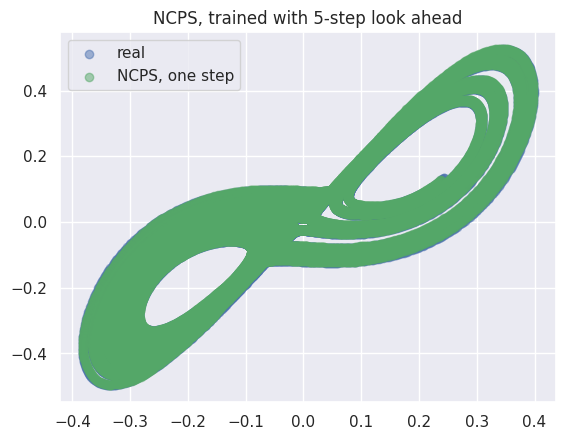

In [57]:
sns.set()
plt.scatter(positions[:, 0], positions[:, 1], alpha=0.5, label="real")
plt.scatter(prediction[:, 0], prediction[:, 1], alpha=0.5, color='g', label="NCPS, one step")
plt.legend()
plt.title("NCPS, trained with 5-step look ahead")

## Save weights

In [58]:
num_s = str(test_samples)
PATH = f"models/RNN_state_dict_N{num_s}"
torch.save(model.state_dict(), PATH)